# Data Preprocessing

## Know Your Data

- Make the data trustworthy, reliable provider preferred
- Summary Statistics: Ranges, averages and medians; histograms or time-series plots; correlations and variances
- Minimal verification: a small subset of predictors, check outliers

Below we show a box plot that illustrates the distribution of correlations between features and the one month ahead return. The correlations are computed on a date-by-date basis, over the whole cross-section of stocks. They are mostly located close to zero, but some dates seem to experience extreme shifts. The market capitalization has the median which is the most negative while volatility is the only predictor with positive median correlation (this particular example seems to refute the low risk anomaly).

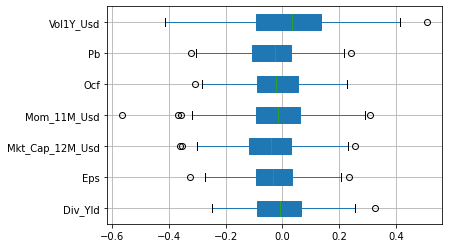

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_ml = pd.read_pickle('./data/data_ml.pkl')
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

cor = data_ml[features_short + ['date', 'R1M_Usd']].groupby('date').corr()['R1M_Usd']
cor = cor.unstack().drop(columns = ['R1M_Usd'])
cor.boxplot(patch_artist = True, vert = False)
plt.show()

We also care about **conditional average**. Suppose there is only one feature $X$ and we seek a model $Y=f(X)+error$, the function $f$ that minimizes the average squared error $\mathbb{E}[(Y-f(X))^2]$ is the so-called regression function $$f(x)=\mathbb{E}[Y|X=x]$$
We plot two illustrations of this function when the dependent variable ($Y$) is the one month ahead return. Both predictors have already been formalized to $[0,1]$.

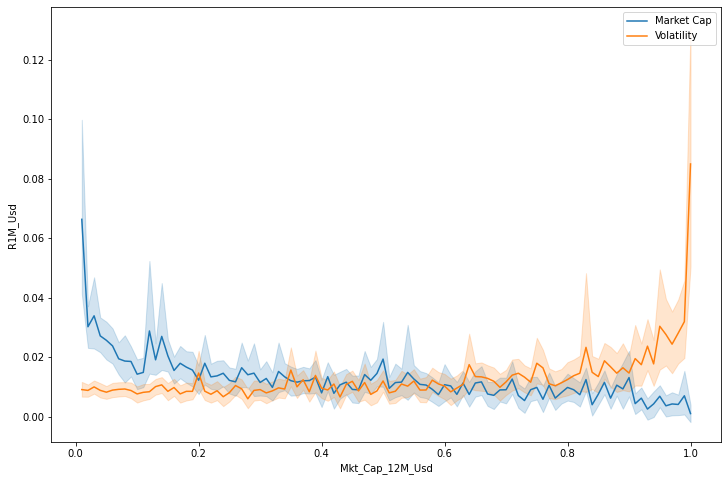

In [23]:
plt.figure(figsize = (12, 8))
sns.lineplot(x = data_ml['Mkt_Cap_12M_Usd'], y = data_ml['R1M_Usd'], label = 'Market Cap')
sns.lineplot(x = data_ml['Vol1Y_Usd'], y = data_ml['R1M_Usd'], label = 'Volatility')
plt.legend()
plt.show()

The two variables have a close to **monotonic impact on future returns**. Returns, on average, decrease with market capitalization (thereby corroborating the so-called size effect). The reverse pattern is less pronounced for volatility: the curve is rather flat for the first half of volatility scores and progressively increases, especially over the last quintile of volatility values (thereby contradicting the low-volatility anomaly).

**Autocorrelation**: high level of autocorrelation makes imputation possible, also important for prediction tasks.

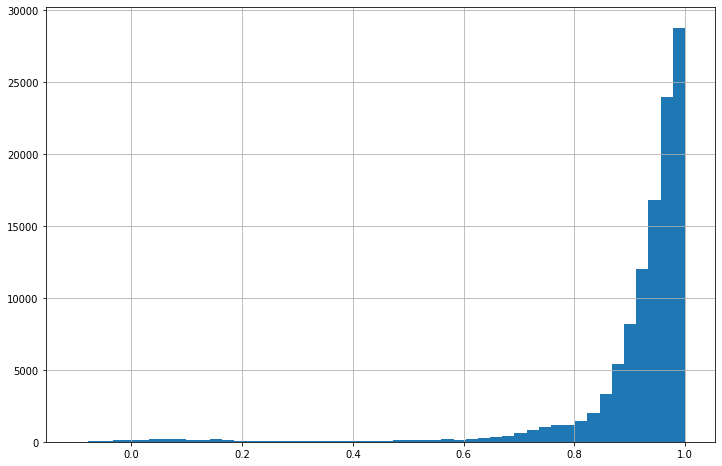

In [38]:
cols = ['stock_id'] + list(data_ml.columns[3:95])
melted_data_ml = pd.melt(data_ml[cols], id_vars = 'stock_id')
data_acf = melted_data_ml.groupby(['stock_id', 'variable']).apply(lambda x: x['value'].autocorr(lag = 1))

plt.figure(figsize=(12, 8))
data_acf.hist(bins = 50, range = [-0.1, 1])
plt.show()

The output shows that predictors are *highly autocorrelated*: most of them have a first order autocorrelation above 0.80.

## Missing Data

Two basic procedures: **removal** and **imputation**.

- Removal: agnostic but costly
- Imputation: multiple choices
  1. Median/Mean over the past available values: can cause trend alternation and forward looking problems
  2. Cross-sectional medians/means: can alter the original distribution
  3. Time-series: replace $x_t$ with $x_{t-1}$, most time make sense but can be a very bad choice in some cases, especially when data are not auto-correlated
  4. Interpolation: never use it on financial data
  5. Non-parametric approaches: advanced

An dividend example: how to fill the missing yield data in June? You may keep previous data, extrapolate from previous observations, or simply set it to 0 (with caution).

## Outlier Detection

- Outside the interval $[\mu-m\sigma, \mu+m\sigma]$, $m$ chosen from ${3,5,10}$
- Largest value is $m$ times to the second-to-largest
- A given small threshold $q$, outside the quantile range $[q,1-q]$

The latter idea was popularized by winsorization, which is
$$
\tilde{x}_i=\begin{cases}
x_i &\text{ if }x_i \in [x^{(q)}, x^{(1-q)}]\\
x^{(q)} &\text{ if }x_i <x^{(q)}\\
x^{(1-q)} &\text{ if }x_i >x^{(1-q)}
\end{cases}
$$
where $x^{(q)}$ is a quantile and $q$ is usually chosen from $(0.5\%,5\%)$, with $1\%$ and $2\%$ being most popular choices. **This must be performed on a feature-by-feature and a date-by-date basis.**

## Feature Engineering

Never do some *garbage in, garbage out* stuff!

### Feature Selection

Filter out unwanted or redundant exogenous variables.

- Correlation Matrix: ensure no absolute value above a threshold (like 0.7)
- Linear Regression: remove non-significant variables
- Clustering Analysis: over a set of features and retain only one within each cluster
- Other Choices: decision tree/random forest for non-linear relationships

### Scaling the Predictors

The choice of normalization may in fact very well matter. Common choices include:

- Standardization: $\tilde{x}_i=(x_i-\mu_x)/\sigma_x$
- Min-max Scaling: $\tilde{x}_i=(x_i-\min(x))/(\max(x)-\min(x))$
- Min-max Scaling (over $[-1,1]$): $\tilde{x}_i=2\dfrac{x_i-\min(x)}{\max(x)-\min(x)}-1$
- Uniformization: $\tilde{x}_i=F_{\mathbf{x}}(x_i)$, where $F_{\mathbf{x}}$ is the empirical c.d.f. of $\mathbf{x}$
- Other transformations: logarithms on positive variables

In factor investing, **the scaling of features must be operated separately for each date and each feature.** It makes sure that for every rebalancing date, **the predictors will have a similar shape** and do carry information on the cross-section of stocks.

**Scaling features across dates should be proscribed.** It completely alter and dilute the cross-sectional content of features.

## Labelling

### Simple Labels

Usual labels in factor investing:

- Raw Asset Returns
- Future Relative Returns
- Probability of a positive return
- Probability of outperforming a benchmark
- The binary version of above: whether or not outperforming
- Risk-adjusted version of above: sharpe ratios, information ratios

### Categorical Labels

Performance proxies: discrete investment decisions. A simple example:
$$
y_{t,i}=\begin{cases}
-1 &\text{ if }\hat{r}_{t,i} <r_{-}\\
0 &\text{ if }\hat{r}_{t,i} \in [r_{-}, r_{+}]\\
+1 &\text{ if }\hat{r}_{t,i} >r_{+}\\
\end{cases}
$$
where $\hat{r}_{t,i}$ is the performance proxy and $r_{\pm}$ are decision thresholds.

Nominal categorical variable: **one-hot encoding** (a sparse matrix).

### The Triple Barrier Method

An advanced labelling method mentioned in De Prado (2018). This idea is to consider the full dynamics instead of a simple performance proxy. Three barriers are fixed:

- One above the current level of the asset (magenta line), which measures a reasonable expected profit
- One below the current level of the asset (cyan line), which acts as a stop-loss signal to prevent large negative returns
- Finally one fixes the horizon of the strategy after which it will be terminated (black line).

Strategy dymanics are as below:
- Strategy hits the first or second barrier $=>$ $+1$ or $-1$
- Strategy hits the last $=>$ $0$ or some linear interpolation between $-1$ and $+1$
- More realistic but computationally consuming

![FIGURE 4.4: Illustration of the triple barrier method](./images/figure4-4.png)

### Filtering the Sample

Extract as much **signal** as possible. More data does not mean more signals but can mean more noises!

Example: filter out the middle 60% of the distribution in a decision tree algorithm. The resulting clusters would be more balanced, and the choice of splitting variables is pushed towards the features that have a monotonic impact on the label. Both are desirable.

However, filtering too much would cause too much loss in signal.

### Return Horizons

Several horizons come into play during the whole ML-driven workflow:

- The horizon of the label
- The estimation window
- The holding periods

Combining smooth features (often highly autocorrelated) with smooth labels is probably a good idea. **1-month returns are weakly auto-correlated while 6-month and 12-month ones are better choices**. Let us assume a single feature $x$ that explains returns: $r_{t+1}=f(x_t)+e_{t+1}$. If $x_t$ is highly auto-correlated and the noise is not too large, then the two-period return $(1+r_{t+1})(1+r_{t+2})-1$ may carry more signal because the influence of $x_t$ has diffused and compounded through time.

## Handling Persistence

Consistency of persistence between features and labels.

One problematic example is when **the dataset is sampled at the monthly frequency with the labels being monthly returns and the features being risk-based or fundamental attributes.** In this case, the label is very weakly autocorrelated, while the features are often highly autocorrelated. In this situation, most sophisticated forecasting tools will arbitrage between features which will probably result in a lot of noise. In linear predictive models, this configuration is known to generate bias in estimates. Two solutions:

- Increase the autocorrelation of the label by computing performance over longer time ranges (e.g. annual)
- Get rid of autocorrelation of features: take **differences**

## Extensions

### Transforming Features

- Lagging: $\tilde{x}_{t,n}^{(k)}=x_{t-1,n}^{(k)}$, useful when features are oscillating
- Ratios or products: insufficient features, like PB, book-to-market, debt-to-equity, etc. Could bring overfitting, so choices should be economically rational
- Consider variations: like $\tilde{x}_{t,n}^{(k)}=x_{t,n}^{(k)}-x_{t-1,n}^{(k)}$

### Macro-economic Variables

Take the context (or the environment) where the data comes from into consideration by adding an exogeneous indicator $z_t$ and generate new predictors like $$\tilde{x}_{t,n}^{(k)}=z_t\times x_{t,n}^{(k)}$$
Sometimes a dynamic thresholding is also useful. An exponential term can do the tricks.

### Active Learning

- Asymmetry in the ability to gather features/labels: obtaining labels can be costly
- Active learning: a filter (often called query) is used to decide which data to label and train on. *Active* means that the learner does not passively accept data samples but actively participates in the choices of items it learns from.
- How to choose the instances to be labelled? 
  1. Heuristically by maximizing learning efficiency
  2. Other methods: estimate the fit that can be obtained when including new instances and then to optimize it. For a training set $D$ and one instance $x$, we have
  $$\mathbb{E}\left[\left.(y-\hat{f}(x;D))^2\right|\{D,x\}\right]=\mathbb{E}\left[\left.\underbrace{(y-\mathbb{E}[y|x])^2}_{\text{indep. from }D\text{ and }\hat{f}} \right|\{D,x\} \right]+(\hat{f}(x;D)-\mathbb{E}[y|x])^2$$
  2. (cont. d) The first term is irreducible as it does not depend on $\hat{f}$. Thus, we only care about the second term. If we take the average of this quantity, taken over all possible values of $D$: $$\mathbb{E}_D\left[(\hat{f}(x;D)-\mathbb{E}[y|x])^2  \right]=\underbrace{\left(\mathbb{E}_D\left[\hat{f}(x;D)-\mathbb{E}[y|x]\right]\right)^2}_{\text{squared bias}} \ + \ \underbrace{\mathbb{E}_D\left[(\hat{f}(x,D)-\mathbb{E}_D[\hat{f}(x;D)])^2\right]}_{\text{variance}}$$ If the expression is not too complicated to compute, the learner can query the $x$ that minimizes the tradeoff.
  3. For factor investing, one possible option is to provide the learner with $\mathbf{X}$ but not $\mathbf{y}$ and keep only a queried subset of observations with corresponding labels.

## Additional Code and Results

### Impact of Rescaling: Graphical Representation


We start with a simple illustration of the different scaling methods. We generate an arbitrary series and then rescale it. The series is not random so that each time the code chunk is executed, the output remains the same.

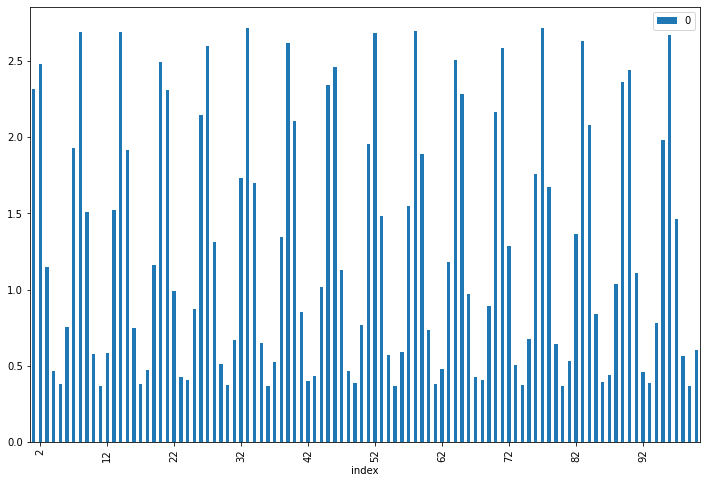

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

length = 100 + 1
x = np.exp(np.sin(np.arange(1, length)))
data_x = pd.DataFrame(x, index = list(range(1, length)))
fig, ax = plt.subplots(figsize=(12, 8))
data_x.plot.bar(ax = ax)
plt.xlabel('index')
plt.xticks(data_x.index[::10])
plt.show()

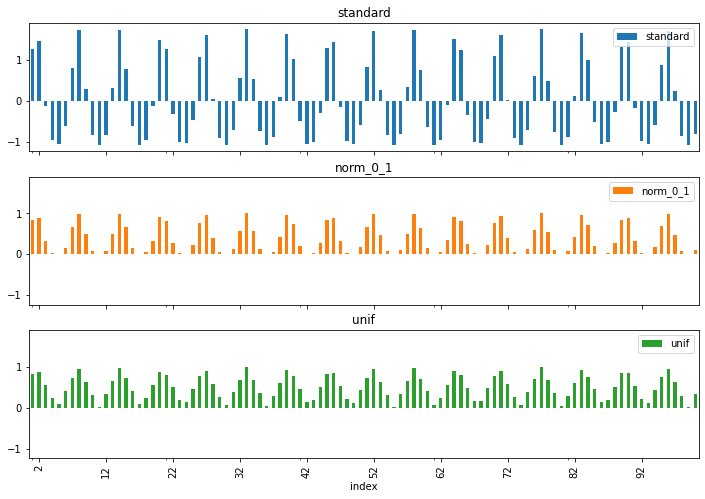

In [58]:
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.preprocessing import StandardScaler, MinMaxScaler

norm_unif = lambda x: ECDF(x)(x)
norm_0_1 = MinMaxScaler()
norm_std = StandardScaler()

data_x['standard'] = norm_std.fit_transform(data_x[0].values.reshape(-1, 1))
data_x['norm_0_1'] = norm_0_1.fit_transform(data_x[0].values.reshape(-1, 1))
data_x['unif'] = norm_unif(data_x[0])
data_x.iloc[:, 1:4].plot.bar(figsize = (12, 8), subplots = True, sharey = True, sharex = True)
plt.xlabel('index')
plt.xticks(data_x.index[::10])
plt.show()

Finally, we look at the histogram of the newly created variables.

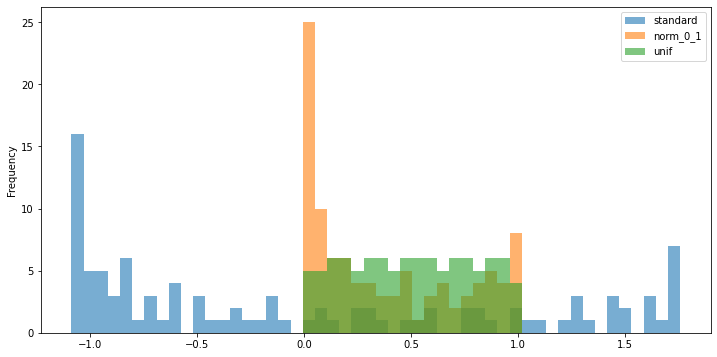

In [64]:
data_x.iloc[:,1:4].plot.hist(alpha = 0.6, bins = 50, figsize = (12, 6))
plt.show()

With respect to shape, the blue and orange distributions are close to the original one. It is only the support that changes: the min/max rescaling ensures all values lie in the $[0,1]$ interval. In both cases, the smallest values (on the left) display a spike in distribution. By construction, this spike disappears under the uniformization: the points are evenly distributed over the unit interval.

### Impact of Rescaling: a Toy Example

To illustrate the impact of choosing one particular rescaling method, we build a simple dataset, comprising 3 firms and 3 dates.

In [102]:
firm = np.array([1] * 3 + [2] * 3 + [3] * 3)
date = np.array([1, 2, 3] * 3)
cap = np.array([10, 50, 100, 15, 10, 15, 200, 120, 80])
rtn = np.array([6, 1, -6, -3, 0, 2, -4, -2, 0]) * 0.01
data_toy = pd.DataFrame([firm, date, cap, rtn], index = ['firm', 'date', 'cap', 'return']).T

data_toy['cap_0_1'] = data_toy.groupby('date')['cap'].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
data_toy['cap_u'] = np.concatenate(data_toy.groupby('date')['cap'].apply(norm_unif).values).ravel() # a little complicated to unravel a list of list
data_toy

,firm,date,cap,return,cap_0_1,cap_u
0,1.0,1.0,10.0,0.06,0.000000,0.333333
1,1.0,2.0,50.0,0.01,0.363636,0.666667
2,1.0,3.0,100.0,-0.06,1.000000,1.000000
3,2.0,1.0,15.0,-0.03,0.026316,0.666667
4,2.0,2.0,10.0,0.00,0.000000,0.333333
5,2.0,3.0,15.0,0.02,0.000000,1.000000
6,3.0,1.0,200.0,-0.04,1.000000,1.000000
7,3.0,2.0,120.0,-0.02,1.000000,0.333333
8,3.0,3.0,80.0,0.00,0.764706,0.666667


Let’s briefly comment on this synthetic data. We assume that dates are ordered chronologically and far away: each date stands for a year or the beginning of a decade, but the (forward) returns are computed on a monthly basis. The first firm is hugely successful and multiplies its cap ten times over the periods. The second firm remains stable cap-wise, while the third one plummets. If we look at ‘local’ future returns, they are strongly negatively related to size for the first and third firms. For the second one, there is no clear pattern.

Date-by-date, the analysis is fairly similar, though slightly nuanced.
- On date 1,  the smallest firm has the largest return and the two others have negative returns.
- On date 2, the biggest firm has a negative return while the two smaller firms do not.
- On date 3, returns are decreasing with size. 

While the relationship is not always perfectly monotonous, there seems to be a link between size and return and, typically, investing in the smallest firm would be a very good strategy with this sample.

Now let us look at the output of simple regressions.

In [108]:
import statsmodels.api as sm
model = sm.OLS(endog = data_toy['return'], exog = sm.add_constant(data_toy['cap_0_1'])).fit()
model.summary2().tables[1]

c:\Users\SamuelZhang\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,0.016278,0.013735,1.185121,0.274639,-0.016201,0.048756
cap_0_1,-0.049703,0.021371,-2.325777,0.052942,-0.100237,0.000830


In [109]:
import statsmodels.api as sm
model = sm.OLS(endog = data_toy['return'], exog = sm.add_constant(data_toy['cap_u'])).fit()
model.summary2().tables[1]

c:\Users\SamuelZhang\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,0.033333,0.029439,1.132277,0.294808,-0.036279,0.102946
cap_u,-0.060000,0.040883,-1.467599,0.185654,-0.156673,0.036673


In terms of $p$-value (column $P>|t|$), the first estimation for the cap coefficient is above 5% while the second is below 5%. One possible explanation for this discrepancy is the standard deviation of the variables. The deviations are equal to 0.34 and 0.27 for cap_norm and cap_u, respectively. Values like market capitalizations can have very large ranges and are thus subject to substantial deviations (even after scaling). Working with uniformized variables reduces dispersion and can help solve this problem.

Note that this is a **double-edged sword: while it can help avoid false negatives, it can also lead to false positives.**

## Coding Exercises

1. The Federal Reserve of Saint Louis (https://fred.stlouisfed.org) hosts thousands of time series of economic indicators that can serve as conditioning variables. Pick one and apply formula (4.3) to expand the number of predictors. If need be, use the function defined above.

Below, we import a credit spread supplied by Bank of America. Its symbol/ticker is “BAMLC0A0CM”. We apply the data expansion on the small number of predictors to save memory space. One important trick that should not be overlooked is the uniformization step after the product (4.3) is computed. Indeed, we want the new features to have the same properties as the old ones. If we skip this step, distributions will be altered, as we show in one example below.

We start with the data extraction and joining. It’s important to join early so as to keep the highest data frequency (daily) in order to replace missing points with close values. Joining with monthly data before replacing creates unnecessary lags.

In [144]:
cred_spread = pd.read_csv('data\chapter4-coding-exercises\BAMLC0A0CM.csv')
cred_spread.columns = ['date', 'spread']
cred_spread['spread'] = cred_spread['spread'].replace('.', 0).astype('float')
cred_spread['date'] = pd.to_datetime(cred_spread['date'])

data_ml = pd.read_pickle('data/data_ml.pkl')
cred_spread = pd.merge(data_ml, cred_spread, how = 'left', on = 'date')
# cred_spread['spread'] = cred_spread['spread'].ffill()
cred_spread = cred_spread.dropna().drop_duplicates().reset_index().drop(columns = 'index')
cred_spread

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,...,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd,R1M_Usd_M,R12M_Usd_M,R1M_Usd_C,R12M_Usd_C,spread
0,1,2018-03-31,0.90,0.88,0.89,0.31,0.45,0.90,1.0,0.98,...,0.67,0.173,0.102,0.015,0.0,0.0035,0.0,1,0,1.17
1,1,2018-04-30,0.90,0.88,0.89,0.31,0.45,0.90,1.0,0.98,...,0.67,-0.042,-0.061,-0.269,0.0,0.0300,0.0,0,0,1.14
2,1,2018-05-31,0.90,0.88,0.89,0.31,0.45,0.90,1.0,0.98,...,0.66,-0.038,-0.095,-0.248,0.0,-0.0020,0.0,0,0,1.22
3,1,2018-06-30,0.90,0.90,0.90,0.35,0.58,0.89,1.0,0.98,...,0.66,0.000,-0.079,-0.304,0.0,0.0240,0.0,0,0,1.30
4,1,2018-07-31,0.90,0.90,0.89,0.35,0.59,0.89,1.0,0.98,...,0.66,-0.077,-0.221,-0.247,0.0,0.0190,0.0,0,0,1.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11037,1212,2018-08-31,0.85,0.84,0.85,0.43,0.93,0.66,1.0,0.93,...,0.85,0.044,-0.252,-0.144,0.0,-0.0110,0.0,1,0,1.21
11038,1212,2018-09-30,0.85,0.84,0.85,0.41,0.87,0.66,1.0,0.94,...,0.84,-0.266,-0.373,0.000,0.0,-0.0790,0.0,0,0,1.13
11039,1212,2018-10-31,0.86,0.87,0.86,0.41,0.91,0.66,1.0,0.94,...,0.87,0.013,0.043,0.000,0.0,0.0360,0.0,0,0,1.25
11040,1212,2018-11-30,0.86,0.88,0.86,0.41,0.91,0.66,1.0,0.94,...,0.87,-0.125,0.157,0.000,0.0,-0.1050,0.0,0,0,1.45


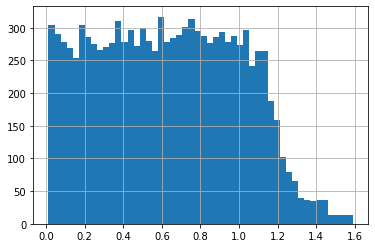

In [153]:
features_short = ['Div_Yld', 'Eps', 'Mkt_Cap_12M_Usd', 'Mom_11M_Usd', 'Ocf', 'Pb', 'Vol1Y_Usd']
names_cred_spread = [feature + "_cred_spread" for feature in features_short]
feat_cred_spread = cred_spread[features_short]
feat_cred_spread.columns = names_cred_spread
feat_cred_spread = feat_cred_spread.apply(lambda x: x * cred_spread['spread'])
feat_cred_spread['Eps_cred_spread'].hist(bins = 50)
plt.show()

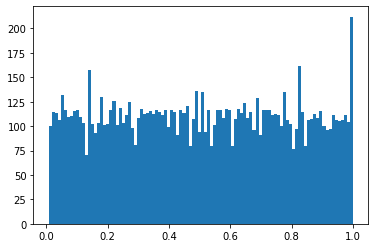

In [161]:
feat_cred_spread['date'] = cred_spread['date']
plt.hist(np.concatenate(feat_cred_spread.groupby('date')['Eps_cred_spread'].apply(norm_unif).values).ravel(), bins = 100)
plt.show()

2. Create a new categorical label based on formulae (4.4) and (4.2). The time series of the VIX can also be retrieved from the Federal Reserve’s website: https://fred.stlouisfed.org/series/VIXCLS.

In [171]:
vix = pd.read_csv('data\chapter4-coding-exercises\VIXCLS.csv')
vix.columns = ['date', 'vix']
vix['date'] = pd.to_datetime(vix['date'])
vix['vix'] = vix['vix'].replace('.', 0).astype('float')

vix = pd.merge(data_ml, vix, on = 'date', how = 'left').dropna().reset_index().drop(columns = 'index')
vix

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,...,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd,R1M_Usd_M,R12M_Usd_M,R1M_Usd_C,R12M_Usd_C,vix
0,1,2018-04-30,0.90,0.88,0.89,0.31,0.45,0.90,1.0,0.98,...,0.67,-0.042,-0.061,-0.269,0.0,0.030,0.0,0,0,15.93
1,1,2018-05-31,0.90,0.88,0.89,0.31,0.45,0.90,1.0,0.98,...,0.66,-0.038,-0.095,-0.248,0.0,-0.002,0.0,0,0,15.43
2,1,2018-07-31,0.90,0.90,0.89,0.35,0.59,0.89,1.0,0.98,...,0.66,-0.077,-0.221,-0.247,0.0,0.019,0.0,0,0,12.83
3,1,2018-08-31,0.90,0.90,0.89,0.35,0.60,0.89,1.0,0.98,...,0.63,-0.002,-0.154,-0.194,0.0,-0.011,0.0,1,0,12.86
4,1,2018-10-31,0.89,0.89,0.90,0.39,0.51,0.89,1.0,0.97,...,0.64,0.014,-0.034,0.000,0.0,0.036,0.0,0,0,21.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7653,1212,2018-07-31,0.85,0.84,0.86,0.43,0.93,0.66,1.0,0.93,...,0.85,0.048,-0.193,-0.158,0.0,0.019,0.0,1,0,12.83
7654,1212,2018-08-31,0.85,0.84,0.85,0.43,0.93,0.66,1.0,0.93,...,0.85,0.044,-0.252,-0.144,0.0,-0.011,0.0,1,0,12.86
7655,1212,2018-10-31,0.86,0.87,0.86,0.41,0.91,0.66,1.0,0.94,...,0.87,0.013,0.043,0.000,0.0,0.036,0.0,0,0,21.23
7656,1212,2018-11-30,0.86,0.88,0.86,0.41,0.91,0.66,1.0,0.94,...,0.87,-0.125,0.157,0.000,0.0,-0.105,0.0,0,0,18.07


In [172]:
vix_med = vix['vix'].median()
delta = 0.5
data_vix = vix[['stock_id', 'date', 'R1M_Usd']].copy()
data_vix['r_minus'] = -0.02 * np.exp(-delta * (vix['vix'] - vix_med))
data_vix['r_plus'] = 0.02 * np.exp(delta * (vix['vix'] - vix_med))
data_vix['R1M_Usd_Cvix'] = 1 * (data_vix['R1M_Usd'] > data_vix['r_plus']) + (-1) * (data_vix['R1M_Usd'] < data_vix['r_minus'])
data_vix

,stock_id,date,R1M_Usd,r_minus,r_plus,R1M_Usd_Cvix
0,1,2018-04-30,-0.042,-0.020000,0.020000,-1
1,1,2018-05-31,-0.038,-0.025681,0.015576,-1
2,1,2018-07-31,-0.077,-0.094229,0.004245,0
3,1,2018-08-31,-0.002,-0.092827,0.004309,0
4,1,2018-10-31,0.014,-0.001413,0.283081,0
...,...,...,...,...,...,...
7653,1212,2018-07-31,0.048,-0.094229,0.004245,1
7654,1212,2018-08-31,0.044,-0.092827,0.004309,1
7655,1212,2018-10-31,0.013,-0.001413,0.283081,0
7656,1212,2018-11-30,-0.125,-0.006860,0.058308,-1


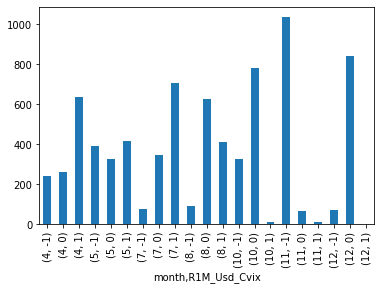

In [181]:
data_vix['month'] = data_vix['date'].apply(lambda x: x.month)
data_vix_nb = data_vix.groupby(['month', 'R1M_Usd_Cvix'])['stock_id'].count()
data_vix_nb.plot.bar()
plt.show()

3. Plot the histogram of the R12M_Usd variable. Clearly, some outliers are present. Identify the stock with highest value for this variable and determine if the value can be correct or not.

<AxesSubplot:>

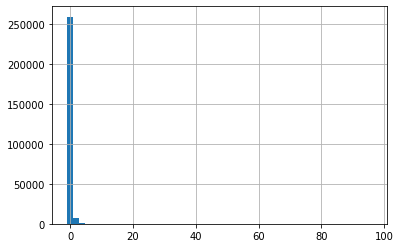

In [185]:
data_ml['R12M_Usd'].hist(bins = 50)

In [187]:
data_ml[data_ml['R12M_Usd'] == data_ml['R12M_Usd'].max()]

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,...,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd,R1M_Usd_M,R12M_Usd_M,R1M_Usd_C,R12M_Usd_C
151571,683,2009-02-28,0.29,0.16,0.27,0.81,0.41,0.23,0.94,0.62,...,0.98,0.98,0.472,2.861,5.778,95.972,0.093,0.63,1,1


The largest return comes from stock #683. Let’s have a look at the stream of monthly returns in 2009.



In [191]:
data_ml['year'] = data_ml['date'].apply(lambda x: x.year)
data_ml[(data_ml['stock_id'] == 683) & (data_ml['year'] == 2009)][["date", "R1M_Usd"]]

,date,R1M_Usd
151570,2009-01-31,-0.625
151571,2009-02-28,0.472
151572,2009-03-31,1.440
151573,2009-04-30,0.139
151574,2009-05-31,0.086
151575,2009-06-30,0.185
151576,2009-07-31,0.363
151577,2009-08-31,0.103
151578,2009-09-30,9.914
151579,2009-10-31,0.101


The returns are all very high, so the annual value is plausible. In addition, a quick glance at the Vol1Y values shows that the stock is the most volatile of the dataset.